In [5]:
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras

In [6]:
def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    print(type(rows))
    data = []
    for row in rows:
        #print(type(row))
        data.append(dict(row))
    return data
registered_users_count = pd.DataFrame(getRegisteredUsersCount())

<class 'list'>


In [7]:
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       30 non-null     object
 1   registered_users_count  30 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 608.0+ bytes


In [8]:
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])

In [9]:
registered_users_count.head()

,registration_date,registered_users_count
0,2019-06-01,4833
1,2019-06-02,5255
2,2019-06-03,4193
3,2019-06-04,4194
4,2019-06-05,3998


In [10]:
registered_users_count['registered_users_count'].sum()

100423

In [11]:
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data 
active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())

In [12]:
active_users_count_with_cohorts

,activity_date,registration_date,active_users_count
0,2019-06-01,2019-06-01,1651
1,2019-06-02,2019-06-01,1429
2,2019-06-02,2019-06-02,1933
3,2019-06-03,2019-06-01,1021
4,2019-06-03,2019-06-02,1550
...,...,...,...
925,2019-07-28,2019-06-29,129
926,2019-07-28,2019-06-30,198
927,2019-07-29,2019-06-29,89
928,2019-07-29,2019-06-30,144


In [13]:
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 930 entries, 0 to 929
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       930 non-null    object
 1   registration_date   930 non-null    object
 2   active_users_count  930 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 21.9+ KB


In [14]:
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])

In [15]:
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-06-01,2019-06-01,1651
1,2019-06-02,2019-06-01,1429
2,2019-06-02,2019-06-02,1933
3,2019-06-03,2019-06-01,1021
4,2019-06-03,2019-06-02,1550


In [16]:
retention_table = active_users_count_with_cohorts.merge(registered_users_count,on='registration_date',how='left')

In [17]:
retention_table

,activity_date,registration_date,active_users_count,registered_users_count
0,2019-06-01,2019-06-01,1651,4833
1,2019-06-02,2019-06-01,1429,4833
2,2019-06-02,2019-06-02,1933,5255
3,2019-06-03,2019-06-01,1021,4833
4,2019-06-03,2019-06-02,1550,5255
...,...,...,...,...
925,2019-07-28,2019-06-29,129,2968
926,2019-07-28,2019-06-30,198,3301
927,2019-07-29,2019-06-29,89,2968
928,2019-07-29,2019-06-30,144,3301


In [18]:
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']

In [19]:
retention_table[(retention_table['activity_date'] == '2019-05-11')&(retention_table['registration_date'] == '2019-05-01')].retention_rate


Series([], Name: retention_rate, dtype: float64)

In [20]:
pd.options.display.float_format = '{:.2%}'.format

In [21]:
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
retention_table['lifetime'].head()

0   0 days
1   1 days
2   0 days
3   2 days
4   1 days
Name: lifetime, dtype: timedelta64[ns]

In [22]:
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int)
# Приведем тип к целому числу 
retention_table['lifetime'].head()

0    0
1    1
2    0
3    2
4    1
Name: lifetime, dtype: int64

In [23]:
retention_table.pivot_table(values='retention_rate',
    index='registration_date',
    columns='lifetime',
    )

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,34.16%,29.57%,21.13%,17.57%,14.36%,13.49%,12.17%,11.28%,11.09%,9.99%,...,6.04%,6.12%,5.88%,5.52%,5.65%,5.07%,4.97%,5.07%,4.20%,2.90%
2019-06-02,36.78%,29.50%,22.13%,18.82%,16.42%,14.56%,13.09%,13.00%,12.16%,10.96%,...,7.31%,7.19%,6.85%,6.28%,6.17%,6.28%,6.32%,6.05%,4.47%,2.89%
2019-06-03,34.15%,29.67%,20.77%,17.34%,15.07%,12.31%,11.81%,11.54%,11.14%,9.92%,...,6.51%,6.49%,6.39%,5.72%,5.63%,5.18%,5.27%,5.20%,4.20%,2.89%
2019-06-04,35.12%,29.69%,22.99%,18.00%,14.76%,13.30%,13.57%,12.18%,10.66%,9.82%,...,6.37%,6.03%,5.84%,5.36%,5.15%,5.20%,5.13%,4.79%,3.62%,2.36%
2019-06-05,33.74%,30.54%,22.31%,17.23%,14.73%,14.06%,13.18%,11.81%,10.83%,9.78%,...,6.60%,6.43%,6.00%,5.63%,5.45%,5.45%,5.35%,5.10%,3.75%,2.75%
2019-06-06,36.28%,30.66%,20.88%,17.89%,16.94%,14.15%,13.10%,11.77%,10.95%,9.85%,...,6.60%,6.37%,6.45%,5.73%,5.66%,5.50%,5.55%,5.53%,4.58%,3.02%
2019-06-07,37.07%,29.47%,21.93%,19.04%,17.12%,14.73%,12.98%,12.10%,10.87%,10.62%,...,6.88%,6.88%,6.82%,6.82%,6.38%,6.47%,6.28%,5.97%,4.52%,2.80%
2019-06-08,36.19%,33.01%,25.14%,20.46%,17.94%,15.63%,14.50%,14.19%,12.72%,11.62%,...,7.67%,7.20%,7.26%,7.20%,6.76%,6.66%,6.66%,6.56%,5.29%,3.75%
2019-06-09,36.40%,32.18%,23.48%,19.27%,16.59%,14.96%,14.38%,13.60%,11.82%,11.31%,...,8.14%,7.47%,7.11%,6.69%,6.80%,6.53%,6.62%,6.24%,4.93%,3.19%


In [24]:
retention_table

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-06-01,2019-06-01,1651,4833,34.16%,0
1,2019-06-02,2019-06-01,1429,4833,29.57%,1
2,2019-06-02,2019-06-02,1933,5255,36.78%,0
3,2019-06-03,2019-06-01,1021,4833,21.13%,2
4,2019-06-03,2019-06-02,1550,5255,29.50%,1
...,...,...,...,...,...,...
925,2019-07-28,2019-06-29,129,2968,4.35%,29
926,2019-07-28,2019-06-30,198,3301,6.00%,28
927,2019-07-29,2019-06-29,89,2968,3.00%,30
928,2019-07-29,2019-06-30,144,3301,4.36%,29


In [25]:
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,34.16%,29.57%,21.13%,17.57%,14.36%,13.49%,12.17%,11.28%,11.09%,9.99%,...,6.04%,6.12%,5.88%,5.52%,5.65%,5.07%,4.97%,5.07%,4.20%,2.90%
2019-06-02,36.78%,29.50%,22.13%,18.82%,16.42%,14.56%,13.09%,13.00%,12.16%,10.96%,...,7.31%,7.19%,6.85%,6.28%,6.17%,6.28%,6.32%,6.05%,4.47%,2.89%
2019-06-03,34.15%,29.67%,20.77%,17.34%,15.07%,12.31%,11.81%,11.54%,11.14%,9.92%,...,6.51%,6.49%,6.39%,5.72%,5.63%,5.18%,5.27%,5.20%,4.20%,2.89%
2019-06-04,35.12%,29.69%,22.99%,18.00%,14.76%,13.30%,13.57%,12.18%,10.66%,9.82%,...,6.37%,6.03%,5.84%,5.36%,5.15%,5.20%,5.13%,4.79%,3.62%,2.36%
2019-06-05,33.74%,30.54%,22.31%,17.23%,14.73%,14.06%,13.18%,11.81%,10.83%,9.78%,...,6.60%,6.43%,6.00%,5.63%,5.45%,5.45%,5.35%,5.10%,3.75%,2.75%
2019-06-06,36.28%,30.66%,20.88%,17.89%,16.94%,14.15%,13.10%,11.77%,10.95%,9.85%,...,6.60%,6.37%,6.45%,5.73%,5.66%,5.50%,5.55%,5.53%,4.58%,3.02%
2019-06-07,37.07%,29.47%,21.93%,19.04%,17.12%,14.73%,12.98%,12.10%,10.87%,10.62%,...,6.88%,6.88%,6.82%,6.82%,6.38%,6.47%,6.28%,5.97%,4.52%,2.80%
2019-06-08,36.19%,33.01%,25.14%,20.46%,17.94%,15.63%,14.50%,14.19%,12.72%,11.62%,...,7.67%,7.20%,7.26%,7.20%,6.76%,6.66%,6.66%,6.56%,5.29%,3.75%
2019-06-09,36.40%,32.18%,23.48%,19.27%,16.59%,14.96%,14.38%,13.60%,11.82%,11.31%,...,8.14%,7.47%,7.11%,6.69%,6.80%,6.53%,6.62%,6.24%,4.93%,3.19%


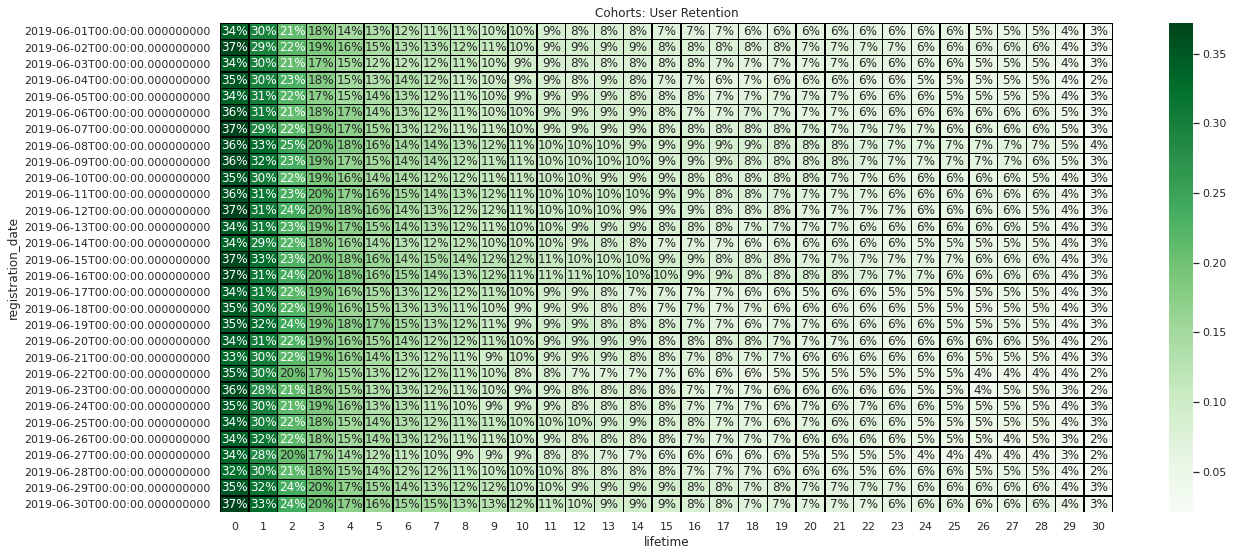

In [26]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, mask=retention_pivot.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black', cmap="Greens");

<AxesSubplot:xlabel='registration_date'>

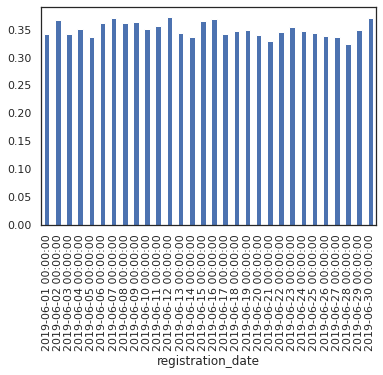

In [27]:
retention_pivot[0].plot.bar()

<AxesSubplot:xlabel='registration_date'>

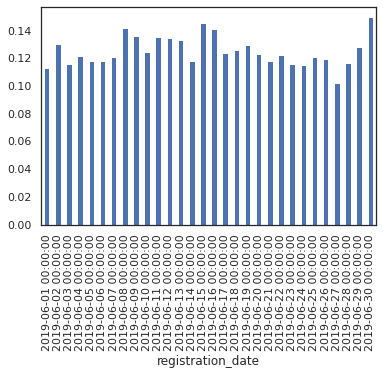

In [28]:
retention_pivot[7].plot.bar()

In [29]:
retention_pivot[7]['2019-06-30']/retention_pivot[7]['2019-06-01']

1.3244076718481195

In [30]:
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data
revenue = pd.DataFrame(getRevenue())

In [31]:
revenue

,date,registration_date,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1082,161186.00%
1,2019-06-02,2019-06-01,928,31773.80%
2,2019-06-02,2019-06-02,1257,130522.00%
3,2019-06-03,2019-06-01,623,19227.30%
4,2019-06-03,2019-06-02,1008,55485.90%
...,...,...,...,...
828,2019-07-28,2019-06-28,38,854.85%
829,2019-07-28,2019-06-29,86,2905.72%
830,2019-07-29,2019-06-29,62,545.99%
831,2019-07-29,2019-06-30,100,1005.40%


In [32]:
revenue.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 833 entries, 0 to 832
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   date                      833 non-null    object 
 1   registration_date         833 non-null    object 
 2   users_count_with_revenue  833 non-null    int64  
 3   revenue                   833 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 26.2+ KB


In [33]:
revenue['date'] = pd.to_datetime(revenue['date'])
revenue['registration_date'] = pd.to_datetime(revenue['registration_date'])

In [34]:
r = revenue['revenue'].sum()
r

79685.877867

In [35]:
u = registered_users_count['registered_users_count'].sum()
u

100423

In [36]:
r/u

0.7935022640928872

In [37]:
revenue = revenue.rename(columns={'date':'activity_date'})

In [38]:
revenue

,activity_date,registration_date,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1082,161186.00%
1,2019-06-02,2019-06-01,928,31773.80%
2,2019-06-02,2019-06-02,1257,130522.00%
3,2019-06-03,2019-06-01,623,19227.30%
4,2019-06-03,2019-06-02,1008,55485.90%
...,...,...,...,...
828,2019-07-28,2019-06-28,38,854.85%
829,2019-07-28,2019-06-29,86,2905.72%
830,2019-07-29,2019-06-29,62,545.99%
831,2019-07-29,2019-06-30,100,1005.40%


In [39]:
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')

In [40]:
retention_table

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime
0,2019-06-01,2019-06-01,1651,4833,34.16%,0
1,2019-06-02,2019-06-01,1429,4833,29.57%,1
2,2019-06-02,2019-06-02,1933,5255,36.78%,0
3,2019-06-03,2019-06-01,1021,4833,21.13%,2
4,2019-06-03,2019-06-02,1550,5255,29.50%,1
...,...,...,...,...,...,...
925,2019-07-28,2019-06-29,129,2968,4.35%,29
926,2019-07-28,2019-06-30,198,3301,6.00%,28
927,2019-07-29,2019-06-29,89,2968,3.00%,30
928,2019-07-29,2019-06-30,144,3301,4.36%,29


In [41]:
retention_table_with_revenue

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
0,2019-06-01,2019-06-01,1651,4833,34.16%,0,108200.00%,161186.00%
1,2019-06-02,2019-06-01,1429,4833,29.57%,1,92800.00%,31773.80%
2,2019-06-02,2019-06-02,1933,5255,36.78%,0,125700.00%,130522.00%
3,2019-06-03,2019-06-01,1021,4833,21.13%,2,62300.00%,19227.30%
4,2019-06-03,2019-06-02,1550,5255,29.50%,1,100800.00%,55485.90%
...,...,...,...,...,...,...,...,...
925,2019-07-28,2019-06-29,129,2968,4.35%,29,8600.00%,2905.72%
926,2019-07-28,2019-06-30,198,3301,6.00%,28,NaN,NaN
927,2019-07-29,2019-06-29,89,2968,3.00%,30,6200.00%,545.99%
928,2019-07-29,2019-06-30,144,3301,4.36%,29,10000.00%,1005.40%


In [42]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 930 entries, 0 to 929
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             930 non-null    datetime64[ns]
 1   registration_date         930 non-null    datetime64[ns]
 2   active_users_count        930 non-null    int64         
 3   registered_users_count    930 non-null    int64         
 4   retention_rate            930 non-null    float64       
 5   lifetime                  930 non-null    int64         
 6   users_count_with_revenue  833 non-null    float64       
 7   revenue                   833 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int64(3)
memory usage: 65.4 KB


In [43]:
#retention_table_with_revenue.fillna(0)

In [44]:
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)

In [45]:
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)

In [46]:
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue'] / retention_table_with_revenue['active_users_count']

In [47]:
retention_table_with_revenue['arppu'] = retention_table_with_revenue['revenue'] / retention_table_with_revenue['users_count_with_revenue']